In [ ]:
# 基础库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sys
import os
# 机器学习库
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import rbf_kernel
# 数据归一化、逆归一化
from sklearn.preprocessing import MinMaxScaler
# 优化相关库
from skopt import gp_minimize
from scipy.optimize import minimize

# 深度学习库
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim

# 忽略警告
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# 中文字体设置
from matplotlib.font_manager import FontProperties
font = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=12)  # 替换为你的中文字体文件路径

# 其他路径设置
sys.path.append(r"C:\Users\haokw\Documents\GitHub\gaolu\MPC\高炉")

# 自定义模块
import base 


In [ ]:
# 检查 DataFrame 中是否包含 NaN 值
def check_if_NaN(data):
    print(data.shape)
    contains_nan = data.isna().any().any()
    if contains_nan:
        print("数据包含 NaN 值")
    else:
        print("数据不包含 NaN 值")


In [ ]:
# 读取Excel文件
excel_path = f'C:\\Users\\haokw\\Documents\\GitHub\\gaolu\\up2\\data\\data.xlsx'
df_sheet_X = pd.read_excel(excel_path, sheet_name='X') 


excel_path = f'C:\\Users\\haokw\\Documents\\GitHub\\gaolu\\up2\\data\\data.xlsx'
df_sheet_Y = pd.read_excel(excel_path, sheet_name='Y') 

check_if_NaN(df_sheet_X)
check_if_NaN(df_sheet_Y)



In [ ]:
input_term =  ['富氧流量', '设定喷煤量', '热风压力', '热风温度']
output_term = ['铁水温度[MIT]', '铁水硅含量[SI]']
time_term=  '时间戳h'


In [ ]:
# 创建数据框副本以避免修改原始数据
df_sheet_X_process = df_sheet_X.copy()
df_sheet_Y_process = df_sheet_Y.copy()


def IQR_process(df_IQR, columns):
    df_IQR = df_IQR
    columns = columns

    print(columns)      # 获取数据框的所有列名
    outlier_indices = set()  # 用于存储异常值的行索引

    # 1. 分别处理每个变量
    for column in columns:
        # 计算描述性统计
        stats = df_IQR[column].describe()

        # 计算IQR（四分位距）以及上下须的范围
        Q1 = stats['25%']
        Q3 = stats['75%']
        IQR = Q3 - Q1
        lower_whisker = Q1 - 1.5 * IQR
        upper_whisker = Q3 + 1.5 * IQR

        # # 绘制箱线图
        # plt.figure(figsize=(8, 6))
        # sns.boxplot(data=df_IQR[column])
        # plt.title(f'Boxplot of {column}', fontproperties=font)
        # plt.xlabel('Feature', fontproperties=font)
        # plt.ylabel('Value', fontproperties=font)
        # plt.show()

        # 查找异常值的索引
        outliers = df_IQR[(df_IQR[column] < lower_whisker) | 
                            (df_IQR[column] > upper_whisker)].index
        outlier_indices.update(outliers)

        # # 打印统计信息和异常值范围
        # print(f"列: {column}")
        # print(f"第一四分位数 (Q1): {Q1}")
        # print(f"第三四分位数 (Q3): {Q3}")
        # print(f"下须 (lower whisker): {lower_whisker}")
        # print(f"上须 (upper whisker): {upper_whisker}")
        # print(f"找到的异常值索引: {list(outliers)}")

        
        # print(f"异常值数量: {len(outliers)}")
        # print(f"总数: {len(df_IQR[column])}")

        # print(f"异常值比例: {len(outliers)/len(df_IQR[column])}\n")

    # 2. 删除所有异常值
    df_cleaned = df_IQR.drop(index=outlier_indices)
    # 重新设置索引，使索引从 0 开始，并丢弃旧索引
    df_cleaned.reset_index(drop=True, inplace=True)
    # 输出处理后的数据框信息
    print(f"原始数据行数: {df_IQR.shape[0]}")
    print(f"删除异常值后的数据行数: {df_cleaned.shape[0]}")

    # 你可以继续对 df_cleaned 进行后续处理



    return df_cleaned


df_cleaned_X = IQR_process(df_sheet_X_process, input_term)
df_cleaned_Y = IQR_process(df_sheet_Y_process, output_term)


In [ ]:
# 画出数据
def plot_subplot(data_x_yuan,data_y_yuan,data_x,data_y,column):
    plt.plot(data_x_yuan,data_y_yuan,'r.')
    plt.plot(data_x,data_y,'m.')
    # plt.xlabel(time_term, fontproperties=font)  # 使用中文标签
    plt.ylabel(column, fontproperties=font)  # 使用中文标签
    # 使用中文标签



plt.figure(figsize=(15, 4))
for idx, column in enumerate(input_term):
    plt.subplot(len(input_term), 1, idx+1)
    plot_subplot(   df_sheet_X[time_term].values,   df_sheet_X[column].values, 
                    df_cleaned_X[time_term].values, df_cleaned_X[column].values,column
                )

plt.figure(figsize=(15, 2))
for idx, column in enumerate(output_term):
    plt.subplot(len(output_term), 1, idx+1)
    plot_subplot(   df_sheet_Y[time_term].values,   df_sheet_Y[column].values, 
                    df_cleaned_Y[time_term].values, df_cleaned_Y[column].values,column
                )



In [ ]:
df_cleaned_X.info()


In [ ]:
length1 = 800
start1 = 0


In [ ]:
# 画出选取的数据
def plot_subplot(data_x,data_y,column,index_predict,index_gaolu):
    plt.plot(data_x,data_y,'-', label='origin_data')
    plt.plot(data_x[index_gaolu],data_y[index_gaolu],'r-', label='gaolu_data')
    plt.plot(data_x[index_predict],data_y[index_predict],'g-', label='predict_data')
    plt.legend()
    # plt.xlabel(time_term, fontproperties=font)  # 使用中文标签
    plt.ylabel(column, fontproperties=font)  # 使用中文标签

# 6509



length2 = 1
start2 = 6507


index_gaolu   = range(start1, start1+length1+1, 1)
index_predict     = range(start2, start2+length2+1, 1)
# index = range(1, 7572, 1)


plt.figure(figsize=(15, 6))
for idx, column in enumerate(input_term):
    plt.subplot(len(input_term+output_term), 1, idx+1)
    plot_subplot(df_cleaned_X[time_term].values, df_cleaned_X[column].values, column, index_predict, index_gaolu)



plt.figure(figsize=(15, 6))
for idx, column in enumerate(output_term):
    plt.subplot(len(input_term+output_term), 1, idx+1)
    plot_subplot(df_cleaned_Y[time_term].values,df_cleaned_Y[column].values,column,index_predict,index_gaolu)



In [ ]:
# 将数据存储为字典，每个键对应一列数据
X_dict_original = {
    input_term[0]:   df_cleaned_X[input_term[0]].values,
    input_term[1]:   df_cleaned_X[input_term[1]].values,
    input_term[2]:   df_cleaned_X[input_term[2]].values,
    input_term[3]:   df_cleaned_X[input_term[3]].values
}
Y_dict_original = {
    output_term[0]:  df_cleaned_Y[output_term[0]].values,
    output_term[1]:  df_cleaned_Y[output_term[1]].values
}





X_dict_original_index_gaolu = {
    input_term[0]:   df_cleaned_X[input_term[0]][index_gaolu].values,
    input_term[1]:   df_cleaned_X[input_term[1]][index_gaolu].values,
    input_term[2]:   df_cleaned_X[input_term[2]][index_gaolu].values,
    input_term[3]:   df_cleaned_X[input_term[3]][index_gaolu].values
}
Y_dict_original_index_gaolu = {
    output_term[0]:  df_cleaned_Y[output_term[0]][index_gaolu].values,
    output_term[1]:  df_cleaned_Y[output_term[1]][index_gaolu].values
}




In [ ]:
# 初始化缩放器
scalers_X = {}
scalers_Y = {}

# 进行拟合
for column, data in X_dict_original.items():
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler.fit(data.reshape(-1, 1))  # 保证数据是列向量
    scalers_X[column] = scaler

for column, data in Y_dict_original.items():
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler.fit(data.reshape(-1, 1))  # 保证数据是列向量
    scalers_Y[column] = scaler




# 进行归一化
X_dict_normal = {}
Y_dict_normal = {}
for column, scaler in scalers_X.items():
    X_dict_normal[column] = scaler.transform(X_dict_original[column].reshape(-1, 1)).flatten()
for column, scaler in scalers_Y.items():
    Y_dict_normal[column] = scaler.transform(Y_dict_original[column].reshape(-1, 1)).flatten()

# 转换为DataFrame
print('全部数据')
X_df_normal = pd.DataFrame(X_dict_normal)
check_if_NaN(X_df_normal)
Y_df_normal = pd.DataFrame(Y_dict_normal)
check_if_NaN(Y_df_normal)



# 高炉部分数据
# 进行归一化
X_dict_normal_index_gaolu = {}
Y_dict_normal_index_gaolu = {}
for column, scaler in scalers_X.items():
    X_dict_normal_index_gaolu[column] = scaler.transform(X_dict_original_index_gaolu[column].reshape(-1, 1)).flatten()
for column, scaler in scalers_Y.items():
    Y_dict_normal_index_gaolu[column] = scaler.transform(Y_dict_original_index_gaolu[column].reshape(-1, 1)).flatten()

# 转换为DataFrame
print('高炉部分数据')
X_df_normal_index_gaolu = pd.DataFrame(X_dict_normal_index_gaolu)
check_if_NaN(X_df_normal_index_gaolu)
Y_df_normal_index_gaolu = pd.DataFrame(Y_dict_normal_index_gaolu)
check_if_NaN(Y_df_normal_index_gaolu)








In [667]:
# 绘制叠加的散点图矩阵。


def plot_scatter_matrix(X_df_normal, X_df_normal_index_gaolu, figsize=(10, 8),font=font, save_path=None):
    """
    绘制叠加的散点图矩阵。

    参数:
    X_df_normal (DataFrame): 第一组数据。
    X_df_normal_index_gaolu (DataFrame): 第二组数据。
    font (FontProperties, optional): 字体属性，用于设置标签的字体。
    """
    # 设置颜色和标记
    color_left = 'blue'
    color_right = 'red'
    marker_left = '.'
    marker_right = '.'

    # 设置数据
    df_left = X_df_normal  # 第一组数据
    df_right = X_df_normal_index_gaolu  # 第二组数据

    # 绘制叠加的散点图矩阵
    plt.figure(figsize = figsize)
    num_cols = len(df_left.columns)
    
    for i, col1 in enumerate(df_left.columns):
        for j, col2 in enumerate(df_left.columns):
            ax = plt.subplot(num_cols, num_cols, i * num_cols + j + 1)
            
            if i != j:
                ax.scatter(df_left[col1], df_left[col2], color=color_left, alpha=0.5, marker=marker_left, label='Left Data' if i == 0 and j == 1 else "")
                ax.scatter(df_right[col1], df_right[col2], color=color_right, alpha=0.5, marker=marker_right, label='Right Data' if i == 0 and j == 1 else "")
                ax.set_xlim([-1, 1])
                ax.set_ylim([-1, 1])
            else:
                ax.hist(df_left[col1], bins=50, alpha=0.5, color=color_left)
                ax.hist(df_right[col1], bins=50, alpha=0.5, color=color_right)
                ax.set_xlim([-1, 1])

            if i == num_cols - 1:
                ax.set_xlabel(col2, fontproperties=font)
            if j == 0:
                ax.set_ylabel(col1, fontproperties=font)

    # # 添加图例
    # plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1))
    # 手动添加图例
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.5, 1))

    # 添加标题并调整布局
    plt.suptitle('Overlaid Scatter Matrix of Features', y=1.02)
    plt.tight_layout()
    
    # 如果提供了保存路径，则保存图像
    if save_path:
        plt.savefig(save_path)
        plt.close()  # 关闭当前的图像，以节省内存
    else:
        plt.show()  # 否则显示图像






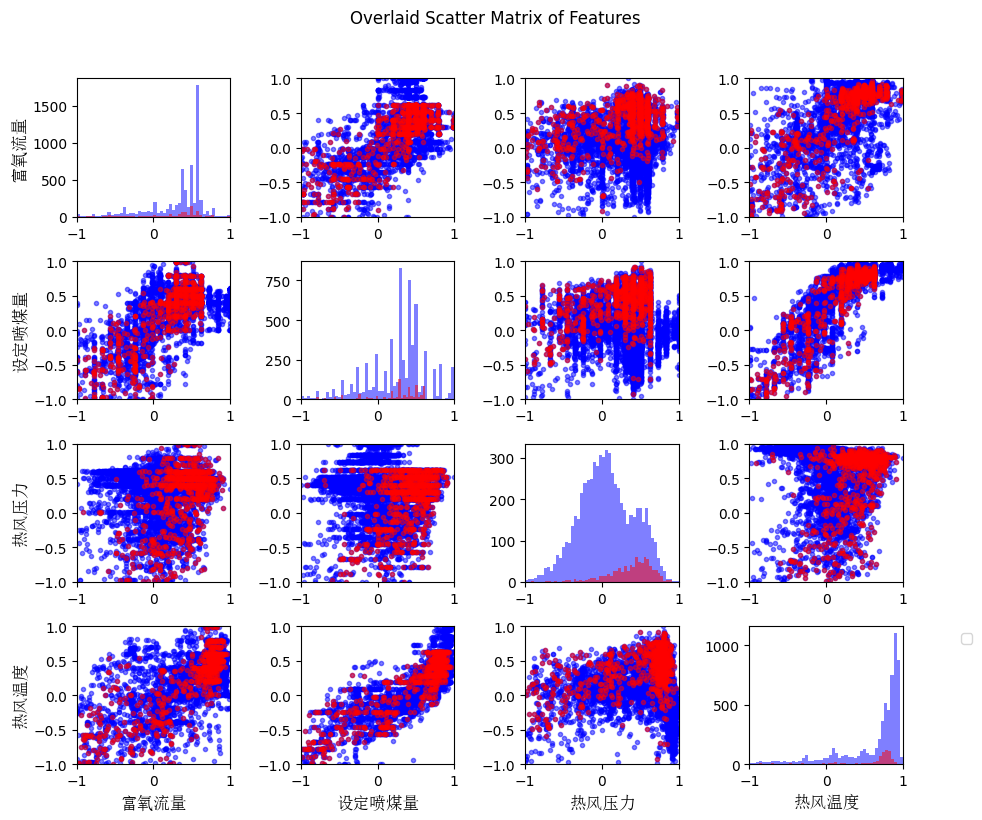

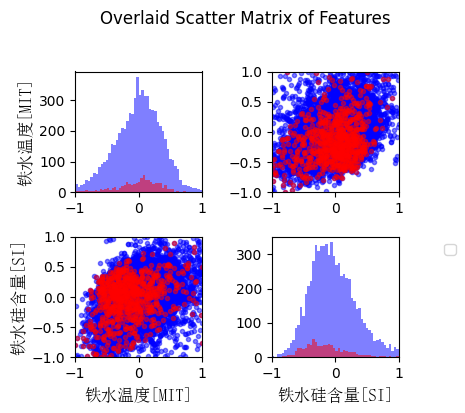

In [668]:
# 绘制散点图矩阵
plot_scatter_matrix(X_df_normal, X_df_normal_index_gaolu, font=font, figsize=(10, 8))
# 绘制散点图矩阵
plot_scatter_matrix(Y_df_normal, Y_df_normal_index_gaolu, font=font, figsize=(5, 4))


In [ ]:
# isShuffle = True
isShuffle = False
time_steps = 3
test_size = 0.15
val_size = 0.15
train_size = 1-val_size-test_size


In [ ]:
# 转换为DataFrame
print('高炉部分数据')
X_df_normal_index_gaolu = pd.DataFrame(X_dict_normal_index_gaolu)
check_if_NaN(X_df_normal_index_gaolu)
Y_df_normal_index_gaolu = pd.DataFrame(Y_dict_normal_index_gaolu)
check_if_NaN(Y_df_normal_index_gaolu)



# 转换为DataFrame
print('全部数据')
X_df_normal = pd.DataFrame(X_dict_normal)
check_if_NaN(X_df_normal)
Y_df_normal = pd.DataFrame(Y_dict_normal)
check_if_NaN(Y_df_normal)



In [ ]:
print(min(X_df_normal.shape[0],Y_df_normal.shape[0]))


In [ ]:
print(X_df_normal.shape)
print(Y_df_normal.shape)
print(df_cleaned_X.info())
print(df_cleaned_Y.info())



In [ ]:
# 组合训练数据--拆分训练、测试集

# 定义时间步数和特征数

# 构成    
# X = [X(t),X(t-1),Y(t-1)]
# Y = [Y(t)]
def make_data(X_df_normal,Y_df_normal,index_gaolu,ifprint):
    X_modified = []
    y_modified = []


    for i in range(0, min(X_df_normal.shape[0],Y_df_normal.shape[0])):
        # print(i)
        if i in index_gaolu:
            # print(i)

            Y_time = df_cleaned_Y[time_term][i]
            # print('输出时间：',df_cleaned_Y[time_term][i])

            closest_10 = df_cleaned_X[df_cleaned_X[time_term] <= Y_time].nlargest(time_steps, time_term)
            # print(closest_10)
            # 检查 closest_10 是否为空
            if closest_10.empty:
                print("No closest values found. closest_10 is empty.")
                continue
                
            index = closest_10.index
            # print(list(index))
            # print(closest_10.iloc[-1][time_term])
            # print(Y_time - time_steps + 1 )

            if closest_10.iloc[-1][time_term] != Y_time - time_steps + 1 :
                # print(i,Y_time)
                print(i,',t',Y_time,',||||  t',closest_10.iloc[0][time_term],',t-time_steps',closest_10.iloc[-1][time_term],'index',index[0],index[-1],'errloss')
            else:
                # print(X_df_normal.loc[index])
                # 拼接行数据 (axis=0 表示纵向拼接)
                new_x_sample = np.concatenate([X_df_normal.loc[i, :].values for i in index], axis=0)
                # print(new_x_sample)
                y_last = Y_df_normal.loc[i-1]
                
                # print(y_last, 'y_last time : ',df_cleaned_Y[time_term][i-1])

                new_x_sample = np.concatenate([new_x_sample,y_last],axis=0)
                # print(new_x_sample)
                y_sample = Y_df_normal.loc[i]
                # print(y_sample)
                X_modified.append(new_x_sample)
                y_modified.append(y_sample)
                print(i,',t',Y_time,',t',closest_10.iloc[0][time_term],',t-time_steps',closest_10.iloc[-1][time_term],'index',index[0],index[-1])


            # break
    
    # 将列表转换为 NumPy 数组
    
    # 查看二维列表的形状
    rows = len(X_modified)
    columns = len(X_modified[0]) if rows > 0 else 0
    print(f"二维列表的形状: ({rows}, {columns})")



    X_modified = np.array(X_modified)
    y_modified = np.array(y_modified)
    X_reshaped = X_modified.reshape((X_modified.shape[0], X_modified.shape[1]))

    # 打印新数据的形状
    print("Modified Input Shape:", X_reshaped.shape)
    print("Modified Output Shape:", y_modified.shape)


    X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_modified, 
                                                        test_size=test_size, 
                                                        random_state=42, 
                                                        shuffle=isShuffle)

    # 将剩余的70%训练数据再次拆分成训练数据和验证数据（20%验证数据，50%训练数据）
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                        test_size=val_size/(train_size+val_size), 
                                                        random_state=42, 
                                                        shuffle=isShuffle)

    print('训练数量：',X_train.shape,y_train.shape)
    print('验证数量：',X_val.shape,y_val.shape)
    print('测试数量：',X_test.shape,y_test.shape)

    return X_train, X_val, X_test, y_train, y_val, y_test






In [ ]:
print('高炉模型数据')
X_gaolu_train, X_gaolu_val, X_gaolu_test,\
y_gaolu_train, y_gaolu_val, y_gaolu_test = make_data(X_df_normal,Y_df_normal,
                                                    index_gaolu,ifprint = True)


In [ ]:
epoch_once_time = 50
ischuangxin = True
# ischuangxin = False
cengshu = 3


In [ ]:
# 定义模型
import torch
import torch.nn as nn
import torch.optim as optim

class MyNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, if_chuangxin = False,gamma = 0.1):
        self.if_chuangxin = if_chuangxin
        super(MyNeuralNetwork, self).__init__()
        if cengshu == 3:    
            if self.if_chuangxin:            
                self.fc1 = nn.Linear(input_size, hidden_size)
                self.relu = nn.ReLU()
                self.fc2 = nn.Linear(hidden_size, hidden_size)
                self.fc3 = nn.Linear(hidden_size, hidden_size)
                self.fc4 = nn.Linear(hidden_size, output_size)
            else:
                self.fc1 = nn.Linear(input_size, hidden_size)
                self.fc2 = nn.Linear(hidden_size, hidden_size)
                self.fc3 = nn.Linear(hidden_size, hidden_size)
                self.fc4 = nn.Linear(hidden_size, output_size)
                self.relu = nn.ReLU()
        elif cengshu == 2:  
            if self.if_chuangxin:            
                self.fc1 = nn.Linear(input_size, hidden_size)
                self.relu = nn.ReLU()
                self.fc2 = nn.Linear(hidden_size, hidden_size)
                self.fc3 = nn.Linear(hidden_size, output_size)
            else:
                self.fc1 = nn.Linear(input_size, hidden_size)
                self.fc2 = nn.Linear(hidden_size, hidden_size)
                self.fc3 = nn.Linear(hidden_size, output_size)
                self.relu = nn.ReLU()


    def forward(self, x0):
        if cengshu == 3:    
            if self.if_chuangxin:

                x = self.fc1(x0)
                x = self.relu(x)

                x2 = self.fc2(x)
                x2 = self.relu(x2)

                x3 = self.fc3(x2)
                x3 = self.relu(x3)

                x4 = x + x2 + x3
                output = self.fc4(x4)
            else:
                x = self.fc1(x0)
                x = self.relu(x)

                x2 = self.fc2(x)
                x2 = self.relu(x2)

                x3 = self.fc3(x2)
                x3 = self.relu(x3)

                output = self.fc4(x3)
        elif cengshu == 2:  
            if self.if_chuangxin:

                x = self.fc1(x0)
                x = self.relu(x)

                x2 = self.fc2(x)
                x2 = self.relu(x2)

                x3 = x + x2
                output = self.fc3(x3)
            else:
                x = self.fc1(x0)
                x = self.relu(x)

                x2 = self.fc2(x)
                x2 = self.relu(x2)

                output = self.fc3(x2)
        return output
        
        return output
    
    

    
    def custom_loss(self, y_true, y_pred):

        squared_diff = torch.pow(y_true - y_pred, 2)
        sum_squared_diff = torch.sum(squared_diff)
        mse = sum_squared_diff / len(y_true)
        return mse
    

    def my_fit(self, 
                X_train, y_train, 
                X_val, y_val, 
                train_loss_list,val_loss_list,
                epochs=1, batch_size=32, lr=0.001):
        optimizer = optim.Adam(self.parameters(), lr=lr)


        for epoch in range(epochs):
            epoch_loss = 0
            for i in range(0, len(X_train), batch_size):
                x_batch = torch.tensor(X_train[i:i+batch_size], dtype=torch.float32)
                y_batch = torch.tensor(y_train[i:i+batch_size], dtype=torch.float32)

                optimizer.zero_grad()
                y_pred = self(x_batch)
                loss = self.custom_loss(y_batch, y_pred)
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()

            average_epoch_train_loss = epoch_loss / (len(X_train) / batch_size)
            # 验证集评估
            self.eval()
            with torch.no_grad():
                val_loss = 0
                for i in range(0, len(X_val), batch_size):
                    x_batch_val = torch.tensor(X_val[i:i+batch_size], dtype=torch.float32)
                    y_batch_val = torch.tensor(y_val[i:i+batch_size], dtype=torch.float32)

                    y_pred_val = self(x_batch_val)
                    val_loss += self.custom_loss(y_batch_val, y_pred_val).item()

                average_epoch_val_loss = val_loss / (len(X_val) / batch_size)

            print(f'第 {epoch + 1}/{epochs} 轮, 训练误差: {average_epoch_train_loss:.4f}, 验证误差: {average_epoch_val_loss:.4f}', end='\r')
            train_loss_list.append(average_epoch_train_loss)
            val_loss_list.append(average_epoch_val_loss)

        return train_loss_list,val_loss_list
    
    def model_update(self, 
                X_train, y_train, 
                epochs=1, batch_size=32, lr=0.001):
        optimizer = optim.Adam(self.parameters(), lr=lr)
        for epoch in range(epochs):
            epoch_loss = 0
            for i in range(0, len(X_train), batch_size):
                x_batch = torch.tensor(X_train[i:i+batch_size], dtype=torch.float32)
                y_batch = torch.tensor(y_train[i:i+batch_size], dtype=torch.float32)

                optimizer.zero_grad()
                y_pred = self(x_batch)
                loss = self.custom_loss(y_batch, y_pred)
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()

            average_epoch_train_loss = epoch_loss / (len(X_train) / batch_size)
            print(f'第 {epoch + 1}/{epochs} 轮, 训练误差: {average_epoch_train_loss:.4f}')
            
            
        return 0
    
    

    def my_predict(self, X_test):
        # 设置模型为评估模式，这会关闭 dropout 等层
        self.eval()
        # 将输入数据转换为张量，并设置 requires_grad=True
        x_tensor = torch.tensor(X_test, dtype=torch.float32, requires_grad=True)
        
        # 获取模型的预测输出
        y_pred = self(x_tensor)
        # 保留预测值的梯度信息
        y_pred.retain_grad()
        # 返回预测结果和包含梯度信息的张量
        return y_pred[:,0].detach().numpy(),y_pred[:,1].detach().numpy()


In [ ]:
# 建立高炉模型实例
input_size = 14  # 10
hidden_size = 16  # 32
output_size = 2  # 输出大小
# 设置随机种子
torch.manual_seed(0)
model_gaolu = MyNeuralNetwork(input_size, 
                            hidden_size,
                            output_size,
                            ischuangxin,
                            gamma = 0.1)
epoch_sum_gaolu = 0
gaolu_train_loss_list = []
gaolu_val_loss_list = []


In [ ]:
# 高炉模型训练
epoch_once = epoch_once_time
epoch_sum_gaolu = epoch_sum_gaolu + epoch_once
gaolu_train_loss_list,gaolu_val_loss_list = model_gaolu.my_fit(X_gaolu_train, y_gaolu_train,
                                    X_gaolu_val, y_gaolu_val, 
                                    gaolu_train_loss_list, gaolu_val_loss_list,
                                    epochs=epoch_once, 
                                    batch_size=32,
                                    lr = 0.002)

print('\nepoch_sum:',epoch_sum_gaolu)

# 绘制训练和验证损失曲线
plt.plot(gaolu_train_loss_list, label='Train Loss')
plt.plot(gaolu_val_loss_list, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()



In [ ]:
# 用于子图编号的字母序列
subplot_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)']
input_term333 =        ['富氧流量', '设定喷煤量', '热风压力', '热风温度']
output_term333 = ['铁水温度MIT', '铁水硅含量[Si]']
time_term= '时间戳h'
# print(input_term333)
# print(output_term333)
input_term222 =        ['富氧流量/(m\u00b3/h)', '设定喷煤量/(t/h)', '热风压力/kPa', '热风温度/℃']
output_term222 = ['铁水温度MIT/℃', '铁水硅含量[Si]/%']
time_term= '时间戳h'
# print(input_term222)
# print(output_term222)

ditem = -0.65

def double_control_train_test_result(scalers_X,scalers_Y, output_term, y_test, y_pred_0, y_pred_1, y_test_2, y_pred_0_2, y_pred_1_2,ditem,a,b):
    y_test_0 = scalers_Y[output_term[0]].inverse_transform((y_test[:, 0]).reshape(-1, 1)).flatten()
    y_test_1 = scalers_Y[output_term[1]].inverse_transform((y_test[:, 1]).reshape(-1, 1)).flatten()
    y_pred_0_inverse_transform = scalers_Y[output_term[0]].inverse_transform((y_pred_0).reshape(-1, 1)).flatten()
    y_pred_1_inverse_transform = scalers_Y[output_term[1]].inverse_transform((y_pred_1).reshape(-1, 1)).flatten()

    output0 = y_test_0 - y_pred_0_inverse_transform
    output1 = y_test_1 - y_pred_1_inverse_transform

    plt.figure(figsize=(9, 8))
    
    
    ax = plt.subplot(4, 1, 1)
    plt.plot(y_test_0,'k', label="真实值")
    plt.plot(y_pred_0_inverse_transform,'r--', label="预测值")
    ax.legend(prop=font, loc='upper right', bbox_to_anchor=(a, b), ncol=4) 
    
    plt.ylabel(output_term222[0], fontproperties=font)  
    ax.yaxis.set_label_coords(-0.07, 0.5)  
    ax.text(0.5, ditem, f'{subplot_labels[0]} {output_term333[0]}建模效果', 
            transform=ax.transAxes, ha='center', fontproperties=font)  
    ax.set_xlabel('训练样本', fontproperties=font)  




    ax = plt.subplot(4, 1, 2)
    plt.plot(y_test_1,'k')
    plt.plot(y_pred_1_inverse_transform,'r--')
    plt.ylabel(output_term222[1], fontproperties=font) 

    ax.yaxis.set_label_coords(-0.07, 0.5)  
    ax.text(0.5, ditem, f'{subplot_labels[1]} {output_term333[1]}建模效果', 
            transform=ax.transAxes, ha='center', fontproperties=font)  
    
    ax.set_xlabel('训练样本', fontproperties=font)  




    y_test_0 = scalers_Y[output_term[0]].inverse_transform((y_test_2[:, 0]).reshape(-1, 1)).flatten()
    y_test_1 = scalers_Y[output_term[1]].inverse_transform((y_test_2[:, 1]).reshape(-1, 1)).flatten()
    y_pred_0_inverse_transform = scalers_Y[output_term[0]].inverse_transform((y_pred_0_2).reshape(-1, 1)).flatten()
    y_pred_1_inverse_transform = scalers_Y[output_term[1]].inverse_transform((y_pred_1_2).reshape(-1, 1)).flatten()

    output0 = y_test_0 - y_pred_0_inverse_transform
    output1 = y_test_1 - y_pred_1_inverse_transform

    ax = plt.subplot(4, 1, 3)
    plt.plot(y_test_0,'k', label="真实值")
    plt.plot(y_pred_0_inverse_transform,'r--', label="预测值")
    plt.ylabel(output_term222[0], fontproperties=font)  
    ax.yaxis.set_label_coords(-0.07, 0.5)  
    ax.text(0.5, ditem, f'{subplot_labels[2]} {output_term333[0]}预测效果', 
            transform=ax.transAxes, ha='center', fontproperties=font)  
    ax.set_xlabel('测试样本', fontproperties=font)  



    ax = plt.subplot(4, 1, 4)
    plt.plot(y_test_1,'k')
    plt.plot(y_pred_1_inverse_transform,'r--')
    plt.ylabel(output_term222[1], fontproperties=font)  
    ax.yaxis.set_label_coords(-0.07, 0.5)  
    ax.text(0.5, ditem, f'{subplot_labels[3]} {output_term333[1]}预测效果', 
            transform=ax.transAxes, ha='center', fontproperties=font)  
    ax.set_xlabel('测试样本', fontproperties=font)  




    plt.subplots_adjust(hspace=0.6)  # 调整子图之间的垂直间距
    plt.tight_layout()  # 自动调整子图布局
    plt.show()



In [ ]:
# 高炉模型建模效果
y_train_pred_0,y_train_pred_1 = model_gaolu.my_predict(X_gaolu_train)
y_test_pred_0,y_test_pred_1 = model_gaolu.my_predict(X_gaolu_test)

double_control_train_test_result(scalers_X,scalers_Y,  output_term,
                                        y_gaolu_train,  y_train_pred_0, y_train_pred_1,
                                        y_gaolu_test ,   y_test_pred_0,  y_test_pred_1,
                                        ditem = -0.65   ,a = 0.63, b = 0.38 )

# base.double_control_train_test_result(scalers,  output_term,
#                                         y_gaolu_train[:-1],  y_train_pred_0[1:], y_train_pred_1[1:],
#                                         y_gaolu_test[:-1] ,   y_test_pred_0[1:],  y_test_pred_1[1:])


In [711]:
# 生成的图像保存路径
output_dir = "GAN_training_output"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)


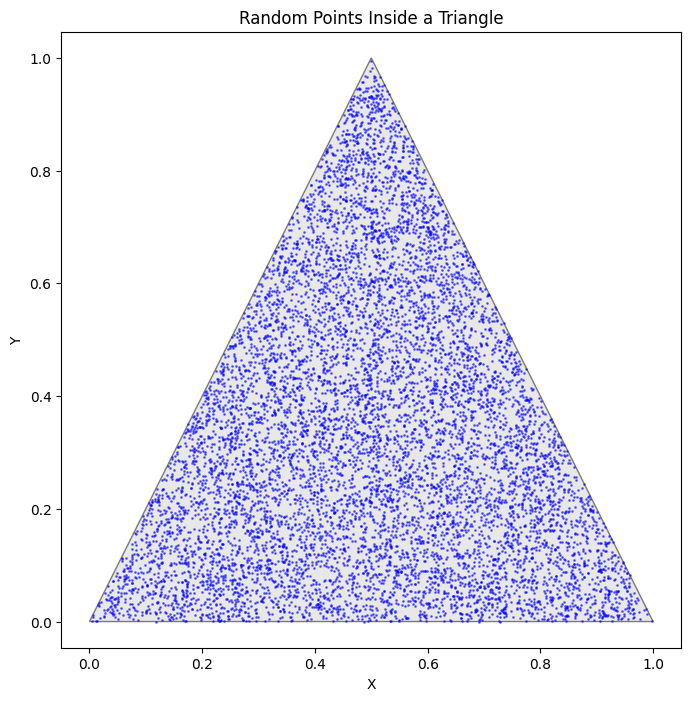

In [705]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.path import Path

# 设置随机种子
np.random.seed(42)

def generate_triangle_data(vertices, num_samples):
    # 创建三角形的路径
    triangle_path = Path(vertices)
    
    # 初始化点
    points = []
    
    # 在三角形内部生成随机点
    while len(points) < num_samples:
        # 生成随机点
        random_point = np.random.rand(2)
        
        # 检查点是否在三角形内部
        if triangle_path.contains_points([random_point]):
            points.append(random_point)
    
    return np.array(points)

# 定义三角形顶点
vertices = np.array([
    [0, 0],  # 顶点A
    [1, 0],  # 顶点B
    [0.5, 1]  # 顶点C
])

# 生成数据
num_samples = 10000
data_test = generate_triangle_data(vertices, num_samples)

# 可视化数据
plt.figure(figsize=(8, 8))
plt.fill(vertices[:, 0], vertices[:, 1], 'lightgray', edgecolor='black', alpha=0.5)  # 填充三角形
plt.scatter(data_test[:, 0], data_test[:, 1], c='blue', alpha=0.5, s=1)
plt.title('Random Points Inside a Triangle')
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('equal')
plt.show()
# 将数据转换为 DataFrame
data_test = pd.DataFrame(data_test, columns=['X', 'Y'])


In [713]:
# 将历史数据转换为 PyTorch 张量
data = torch.tensor(X_df_normal.values, dtype=torch.float32)
data = torch.tensor(data_test.values, dtype=torch.float32)

# 设置数据加载器
batch_size = 64
data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)


In [714]:
# 生成器模型
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, output_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

# Critic 模型（类似于判别器，但输出实数值）
class Critic(nn.Module):
    def __init__(self, input_dim):
        super(Critic, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.model(x)

# 权重裁剪函数
def weight_clipping(critic, clip_value=0.01):
    for param in critic.parameters():
        param.data.clamp_(-clip_value, clip_value)


In [715]:
# 超参数
z_dim = 100  # 随机噪声维度
data_dim = data.shape[1]  # 数据维度，4
learning_rate = 0.0002
num_epochs = 20000
n_critic = 5  # 每次更新生成器前，更新 Critic 的次数
clip_value = 0.01  # 权重裁剪范围

# 初始化生成器和 Critic
generator = Generator(z_dim, data_dim)
critic = Critic(data_dim)

# 设置优化器
optimizer_G = optim.RMSprop(generator.parameters(), lr=learning_rate)
optimizer_C = optim.RMSprop(critic.parameters(), lr=learning_rate)


In [716]:
# WGAN的训练

# df_wang = X_df_normal
df_wang = data_test
for epoch in range(num_epochs):
    for real_data in data_loader:
        batch_size = real_data.size(0)

        # 更新 Critic
        for _ in range(n_critic):
            z = torch.randn(batch_size, z_dim)
            fake_data = generator(z)

            # 计算 Critic 的损失（Wasserstein 距离）
            real_output = critic(real_data)
            fake_output = critic(fake_data.detach())
            c_loss = -torch.mean(real_output) + torch.mean(fake_output)

            optimizer_C.zero_grad()
            c_loss.backward()
            optimizer_C.step()

            # 对 Critic 权重进行裁剪
            weight_clipping(critic, clip_value)

        # 更新生成器
        z = torch.randn(batch_size, z_dim)
        fake_data = generator(z)
        fake_output = critic(fake_data)
        g_loss = -torch.mean(fake_output)

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

    print(f"Epoch [{epoch}/{num_epochs}], c_loss: {c_loss.item():.4f}, g_loss: {g_loss.item():.4f}")
    if epoch % 10 == 0:
        # 生成一些数据
        z = torch.randn(6000, z_dim)
        generated_data = generator(z).detach().numpy()
        
        # 将生成的数据转换为 DataFrame
        generated_df = pd.DataFrame(generated_data, columns=df_wang.columns)

        # 构建保存路径和文件名
        filename = f"Epoch_{epoch}_c_loss_{c_loss.item():.4f}_g_loss_{g_loss.item():.4f}.png"
        save_path = os.path.join(output_dir, filename)

        # 可视化生成的数据分布
        plot_scatter_matrix(df_wang, generated_df,figsize=(10, 8), font=font, save_path = save_path)




Epoch [0/20000], c_loss: -0.0001, g_loss: -0.0097
Epoch [1/20000], c_loss: -0.0003, g_loss: -0.0099
Epoch [2/20000], c_loss: -0.0003, g_loss: -0.0061
Epoch [3/20000], c_loss: 0.0000, g_loss: -0.0097
Epoch [4/20000], c_loss: 0.0002, g_loss: -0.0089
Epoch [5/20000], c_loss: -0.0000, g_loss: -0.0089
Epoch [6/20000], c_loss: -0.0005, g_loss: -0.0063
Epoch [7/20000], c_loss: 0.0000, g_loss: -0.0092
Epoch [8/20000], c_loss: -0.0005, g_loss: -0.0124
Epoch [9/20000], c_loss: -0.0000, g_loss: -0.0091
Epoch [10/20000], c_loss: -0.0002, g_loss: -0.0091
Epoch [11/20000], c_loss: 0.0000, g_loss: -0.0083
Epoch [12/20000], c_loss: -0.0001, g_loss: -0.0071
Epoch [13/20000], c_loss: 0.0000, g_loss: -0.0074
Epoch [14/20000], c_loss: 0.0001, g_loss: -0.0073
Epoch [15/20000], c_loss: -0.0000, g_loss: -0.0082
Epoch [16/20000], c_loss: -0.0000, g_loss: -0.0093
Epoch [17/20000], c_loss: 0.0001, g_loss: -0.0093
Epoch [18/20000], c_loss: -0.0004, g_loss: -0.0091
Epoch [19/20000], c_loss: -0.0001, g_loss: -0.00